Set up environment
----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import new_colormaps as cm

import matplotlib
%matplotlib inline

import os
import sys
import itertools

import pyemma
print (pyemma.__version__)

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from msmtools.generation import generate_trajs

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2.2


Useful functions
----

In [2]:
def cosd(deg):
    return np.cos(deg/180. * np.pi)

def sind(deg):
    return np.sin(deg/180. * np.pi)

def xyz2fracM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [1./a, -cosd(gamma)/a/sind(gamma), (cosd(alpha)*cosd(gamma)-cosd(beta)) / a/v/sind(gamma)]
    r2 = [0, 1./b/sind(gamma), (cosd(beta)*cosd(gamma)-cosd(alpha)) / b/v/sind(gamma)]
    r3 = [0, 0, sind(gamma)/c/v]
    M = np.array([r1, r2, r3])
    return M

def frac2xyzM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [a, b*cosd(gamma), c*cosd(beta)]
    r2 = [0, b*sind(gamma), c*(cosd(alpha)-cosd(beta)*cosd(gamma))/sind(gamma)]
    r3 = [0, 0, c*v/sind(gamma)]
    M = np.array([r1, r2, r3])
    return M

def wrap(x, y, z, Mfwd, Mrev):
    fxyz = np.dot(Mfwd, np.array([x, y, z]))
    fxyz_ = fxyz % 1
    wrapped = np.dot(Mrev, np.array(fxyz_))
    wrapped = np.around(wrapped, 8)
    return wrapped 


# # Function to read the dump file

def read_file(infiles, frames, ps_per_timestep):
    t = []
    xyz = []
    for infile in infiles:
        with open(infile, 'r') as fin:
            for line in fin:
                if len(t)<=frames:
                    line_chunks = line.split()
                    if line_chunks[0] != '#':
                        try:
                            ind, x, y, z = map(float, line_chunks)
                            ind = int(line_chunks[0])
                            xyz.append([x, y, z])
                        except:
                            simtime, N = map(int, line_chunks)
                            t.append(float(simtime))

    # Convert timestep to time
    t = (np.array(t) - t[0]) * ps_per_timestep

    # Get number of frames and reshape data array
    numframes =  len(xyz) // N
    xyz = np.reshape(xyz, (numframes, N, 3))

    out = {}
    out['xyz'] = xyz
    out['numframes'] = numframes
    out['mlc'] = N
    out['t_ps'] = t
    
    if debug:
        print ("Finished read_file of {}".format(infiles))
        
    return out


def wrapcoords(alldata, Mfwd, Mrev):
    N, trj, dim = np.shape(alldata)
    alldataT= np.transpose(alldata)
    xyz_wrap_T = np.empty((dim, trj, N))
    for i in range(trj):
        frac_T = np.dot(Mfwd, alldataT[:,i,:])
        
        # wrap unit cell coordinates
        frac_wrap_T = frac_T % 1

        # convert fractional to cartesian coords
        xyz_wrap_T[:, i, :] = np.dot(Mrev, frac_wrap_T)

    xyz_wrap = np.transpose(xyz_wrap_T)
    
    if debug:
        print ("finished wrapcoords")
    return xyz_wrap

User defined
----

In [3]:
debug = True

adsorbate = 'propane'
trjs = 160
T = 298
Nframes = 4000  # only do partial read of file?

# name of dumpfile
dumpfile = os.path.join('lammps_3_extend.dump')

fs_per_timestep = 1
timesteps_per_frame = 1000

crystal = {}
crystal['a'] = 39.97
crystal['b'] = 40.00
crystal['c'] = 16.58
crystal['alpha'] = 90
crystal['beta'] = 90
crystal['gamma'] = 120

# designate path from which to read/write files
activedir = os.path.join('{}_N{}_T{}_ff{}'.format(adsorbate, trjs, T, Nframes))
if not os.path.exists(activedir):
    os.makedirs(activedir)

Read dumpfile to obtain data
----

In [4]:
# convert frame indices to ns
ps_per_timestep = 1e-3 * fs_per_timestep  # (5e-4)
ps_per_frame = ps_per_timestep * timesteps_per_frame  # (5e-1)
ns_per_frame = 1e-3 * ps_per_frame  # (5e-4)

# read data file
data = read_file([dumpfile], Nframes, ps_per_timestep)
Nframes = data['numframes']
mydat_u_orig = data['xyz']

Finished read_file of ['lammps_3_extend.dump']


In [5]:
class data:
    def __init__(self, origdata, crystal_prms):
        self.origdata = origdata
        self.crystal_prms = crystal_prms
                            
    @property
    def Mfwd(self):
        return xyz2fracM(self.crystal_prms)

    @property
    def Mrev(self):
        return frac2xyzM(self.crystal_prms)

    @property
    def Nframes(self):
        return np.shape(self.origdata)[0]

    @property
    def Ntrjs(self):
        return np.shape(self.origdata)[1]

    
    def unwrapped(self):
        return self.origdata
    
    def wrapped(self):
        return wrapcoords(self.origdata, self.Mfwd, self.Mrev)

    #-------------------------------------------------
    # create list of ndarrays(trjs,dims) using indices
    #-------------------------------------------------

    def get_xyz_region(self, hexregions=1):  # hexregions=1 is to split meso/micro
        xyz = self.unwrapped()
        xyz_wrap = self.wrapped()

        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2

        region = np.ones((self.Nframes, self.Ntrjs, 1), dtype=int)  # default to region 1 (micro)
                                                                    # region 2 is meso outer, and so on until hexregions+1

        for i in range(hexregions):
            radius = 17 * np.sqrt(1 - 1.*i/hexregions)
            for P in [P1, P2, P3, P4]:
                s2 = np.sum(np.power(xyz_wrap - P, 2)[:,:,0:2], axis=2)
                region[:,:, 0] +=  (s2 <= radius**2)*1  # regions are numbered increasing to the center of channel

        #combined = np.concatenate((xyz, region, xyz_wrap), axis=2)
        reg1 = region==1
        reg2 = region==2
        
        microxyz_w = xyz_wrap*reg1
        mesoxyz_w = xyz_wrap*reg2
    
        combined = np.concatenate((xyz, region, microxyz_w), axis=2)

        return combined

        
    def group_ind(self):
        xyzdata = self.get_xyz_region()
        indices = {}
        indices[1] = []
        indices[2] = []
            
        first = 0
        last = 0
        for p in range(self.Ntrjs):
            for i,v in enumerate(itertools.groupby(xyzdata[:,p,:], lambda x: x[3])):
                key, group = v
                N = len(list(group))
                last = first + N
                indices[int(key)].append((first, last))
            
                first = last
        return indices


    def micro_u(self, region=1):
        xyz = self.unwrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def micro_w(self, region=1):
        xyz = self.wrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def meso_u(self, region=2):
        xyz = self.unwrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data
        
    def meso_w(self, region=2):
        xyz = self.wrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def xyz2sz(self):
        xyz = self.wrapped()
        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2


        s1 = np.sqrt(np.sum((xyz[:,:,0:2]-P1[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s2 = np.sqrt(np.sum((xyz[:,:,0:2]-P2[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s3 = np.sqrt(np.sum((xyz[:,:,0:2]-P3[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s4 = np.sqrt(np.sum((xyz[:,:,0:2]-P4[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s0 = np.minimum(s1, s2)
        s0 = np.minimum(s0, s3)
        s0 = np.minimum(s0, s4)


        sz = {}
        sz['composite'] = np.zeros((self.Nframes, self.Ntrjs, 2))
        sz['meso'] = np.zeros((self.Nframes, self.Ntrjs, 2))
        sz['micro'] = np.zeros((self.Nframes, self.Ntrjs, 2))

        # micro
        tmp = s0 > 17
        s = tmp*s0
        z = tmp*xyz[:,:,2]
        sz['micro'][:,:,0] = s
        sz['micro'][:,:,1] = z
        
        # meso
        tmp = s0 < 17
        s = tmp*s0
        z = tmp*xyz[:,:,2]
        sz['meso'][:,:,0] = s
        sz['meso'][:,:,1] = z
        
        # composite
        tmp = s0 > 0
        s = tmp*s0
        z = tmp*xyz[:,:,2]
        sz['composite'][:,:,0] = s
        sz['composite'][:,:,1] = z
        
        return sz
    
    def tica_sz(self, which):  # region 1 is microchannel
        sz = self.xyz2sz()[which]
        sz_ = np.reshape(sz, (self.Nframes * self.Ntrjs, 2), order='F')

        data ={}
        data['name'] = which
        data['data'] = []

        region = {'composite': 0, 'micro': 1, 'meso': 2}

        if which=='micro' or which=='meso':
            for i in self.group_ind()[region[which]]:
                ff, lf = i
                tmp = sz_[ff:lf, :]
                data['data'].append(tmp)

        if which=='composite':
            for i in xrange(np.shape(sz)[1]):
                data['data'].append(sz[:,i,:])

        return data
        

x = data(mydat_u_orig, crystal)

Visualize trajectory data
----

finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords


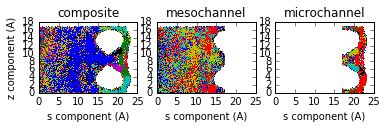

In [37]:
# use this to visualize data
if 1:
    
    
    plt.close('all')
    plt.figure()
    
    plt.subplot(131)
    plt.title('composite')
    plt.gca().set_aspect('equal')
    for i in x.tica_sz('composite')['data']:
        plt.plot(i[:,0], i[:,1], ls='', marker=',')
    plt.xlim(0,25)
    plt.xlabel('s component (A)')
    plt.ylabel('z component (A)')
    
    plt.subplot(132)
    plt.title('mesochannel')
    plt.gca().set_aspect('equal')
    for i in x.tica_sz('meso')['data']:
        plt.plot(i[:,0], i[:,1], ls='', marker=',')
    plt.xlim(0,25)
    plt.xlabel('s component (A)')
    
    plt.subplot(133)
    plt.title('microchannel')
    plt.gca().set_aspect('equal')
    for i in x.tica_sz('micro')['data']:
        plt.plot(i[:,0], i[:,1], ls='', marker=',')
    plt.xlim(0,25)
    plt.xlabel('s component (A)')
    
    
    plt.show()
    

finished wrapcoords
finished wrapcoords


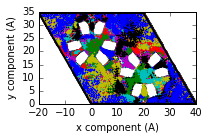

In [38]:
if 1:
  plt.close('all')

  xw = x.wrapped()
  plt.figure(figsize=(3,3))
  for i in xrange(np.shape(x.wrapped())[1]):
    plt.plot(xw[:,i,0], xw[:,i,1], ls='', marker='.', ms=2)
  plt.gca().set_aspect('equal')
  plt.xlabel('x component (A)')
  plt.ylabel('y component (A)')

  plt.plot([0, 39.97, 19.97, -20, 0], [0, 0, 34.641, 34.641, 0], c='k', lw=2)
  plt.tight_layout()
#  plt.savefig('{}/wrapped_unitcell_big'.format(activedir), dpi=144)

finished wrapcoords


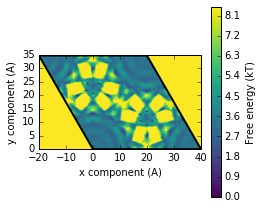

In [39]:
if 1:
    plt.figure(figsize=(3.7,3))
    tmp = np.vstack(np.swapaxes(x.wrapped(), 0,1).tolist())
    pyemma.plots.plot_free_energy(tmp[:,0], tmp[:,1], cmap=cm.viridis, cbar=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('x component (A)')
    plt.ylabel('y component (A)')
    plt.ylim(0,35)
    plt.plot([0, 39.97, 19.97, -20, 0], [0, 0, 34.641, 34.641, 0], c='k', lw=2)
    plt.tight_layout()

Define lag time and discretize trajectories
----

In [7]:
def discretize(mydata, msm_lag=40, n_clusters=128):
    
    print ('lag time: {}'.format(msm_lag))
    
    # For a defined lag time,
    # Discard shortest trajectories until median trjlength is roughly 4x lag time
    # Discretize trajectories and 
    # Estimate markov model to ensure that states are connected

    
    trajlengths = np.array([len(i) for i in mydata['data']])
    for i in range(1,1000):
        minlen = i
        tmp = trajlengths[trajlengths>=minlen]
        if msm_lag <= 2*np.median(tmp):
            medianlen = np.median(tmp)
            meanlen = np.mean(tmp)
            break
    print ('min trjlen:   {:>8}'.format(minlen))
    print ('median trjlen:{:>8.0f}'.format(medianlen))
    print ('mean trjlen:  {:>8.0f}'.format(meanlen))

    
    stride = max(1, (Nframes*trjs)//100000)
    print ('stride: {}'.format(stride))

    # get cluster centers using k-means clustering
    tmpY = [i for i in mydata['data'] if len(i)>=medianlen]
    clustering = coor.cluster_kmeans(data=tmpY, k=n_clusters, max_iter=200, stride=stride, fixed_seed=True)

    # remove smaller trajectories (hack! only use to circumvent coarse_grain error -- do not use!)
    tmpY2 = [i for i in mydata['data'] if len(i)>=minlen]

    # which data to use? 
    #Y = tmpY2
    Y = mydata['data']

    # assign full data set to cluster centers
    dtrajs = pyemma.coordinates.assign_to_centers(data=Y, centers=clustering.clustercenters)

    # Estimate Markov model to ensure states are connected
    M = msm.estimate_markov_model(dtrajs, msm_lag, sparse=False)
    print ('\n\nMake sure these are both 1.0!')
    print ('fraction of states used = {}'.format(M.active_state_fraction))  # len(M.active_set) / n_clusters
    print ('fraction of counts used = {}'.format(M.active_count_fraction))

    region = mydata['name']
    return dtrajs, n_clusters, msm_lag, Y, clustering, region


#dtrajs, n_clusters, msm_lag, Y, clustering, region = discretize(x.tica_sz('composite'), n_clusters=1024, msm_lag=20)  # trj400
dtrajs, n_clusters, msm_lag, Y, clustering, region = discretize(x.tica_sz('micro'), n_clusters=512, msm_lag=8)  # trj400
#dtrajs, n_clusters, msm_lag, Y, clustering, region = discretize(x.tica_sz('meso'), n_clusters=512, msm_lag=4)


finished wrapcoords
finished wrapcoords
lag time: 8
min trjlen:          3
median trjlen:       5
mean trjlen:        50
stride: 6
31-05-16 13:03:09 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 6 steps.


Make sure these are both 1.0!
fraction of states used = 1.0
fraction of counts used = 1.0


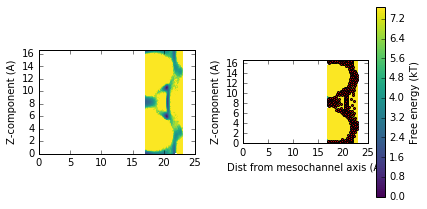

In [8]:
def dtraj_fig(dtrajs):
    
  if 1:    
    plt.figure(figsize=(6,3))
    
    plt.subplot(121)
    pyemma.plots.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap=cm.viridis, cbar=False)
    plt.gca().set_aspect('equal')
    #plt.xlabel('Distance from mesochannel axis (A)')
    plt.ylabel('Z-component (A)')
    plt.xlim(0,25)
    plt.ylim(0,crystal['c'])
    #plt.xticks([17,19,21,23])
    #plt.scatter(clustering.clustercenters[:,0], clustering.clustercenters[:,1], c='r')


    plt.subplot(122)
    pyemma.plots.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap=cm.viridis)
    plt.scatter(clustering.clustercenters[:,0], clustering.clustercenters[:,1], c='r', s=4)
    plt.gca().set_aspect('equal')
    plt.xlabel('Dist from mesochannel axis (A)')
    plt.ylabel('Z-component (A)')
    plt.xlim(0,25)
    plt.ylim(0,crystal['c'])
    #plt.xticks([17,19,21,23])

    plt.tight_layout()
    plt.savefig('{}/dtrj0_{}.png'.format(activedir, n_clusters), dpit=144)

    

    return

dtraj_fig(dtrajs)

Check lag time against implied timescales
----

In [9]:
its = msm.timescales_msm(dtrajs, nits=10, n_jobs=-1)

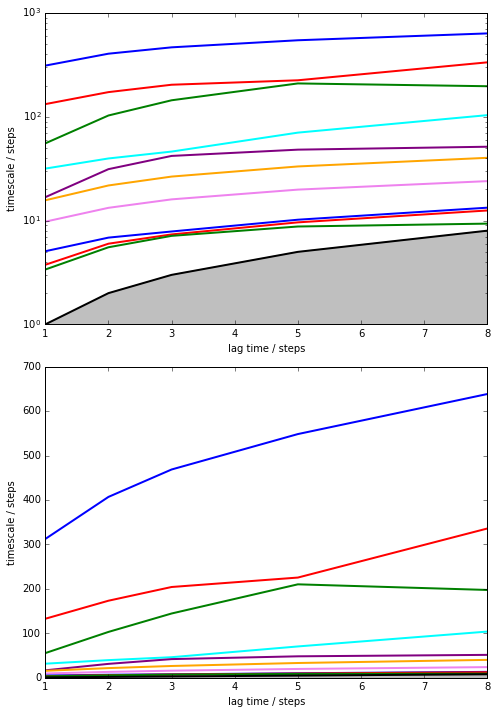

In [10]:
plt.close('all')
plt.figure(figsize=(7,10))

plt.subplot(211)
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)
plt.axvline(msm_lag, c='r', ls='--')

plt.subplot(212)
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
plt.axvline(msm_lag, c='r', ls='--')

plt.tight_layout()
plt.savefig('{}/its_{}.png'.format(activedir, n_clusters), dpi=144)
#plt.show()

MSM
----

In [11]:
M = msm.bayesian_markov_model(dtrajs, msm_lag, nsamples=100)  # default nsamples is 100

Analyze MSM output
----

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


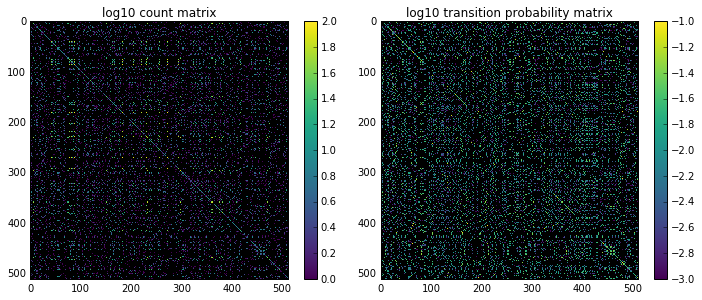

In [12]:
def show_trans_mat(M):
        
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)
    plt.imshow(np.log10(M.count_matrix_active), cmap=cm.viridis, vmin=0, vmax=2, interpolation='nearest')
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.title('log10 count matrix')

    plt.subplot(122)
    plt.imshow(np.log10(M.transition_matrix), cmap=cm.viridis, vmin=-3, vmax=-1, interpolation='nearest')
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.title('log10 transition probability matrix')

    plt.tight_layout()
    plt.savefig('{}/matrix_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)

    return

plt.close('all')
show_trans_mat(M)


Spectral analysis
=====

In [13]:
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=cm.viridis, cbar=True, 
                          cbar_label=None, vmin=None, vmax=None):
    # histogram data
    xmin = np.amin(xall)
    xmax = np.amax(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.amin(yall)
    ymax = np.amax(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    #eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = plt.gca()
    cf = ax.contourf(z.T, nlevels, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    if cbar:
        cbar = plt.colorbar(cf)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
            
    return ax


def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=cm.viridis, cbar=True, cbar_label=None, vmin=None, vmax=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, 
                                 cbar=cbar, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

View eigenvectors
----

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


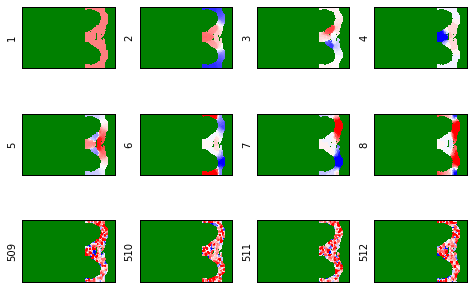

In [14]:
def show_eigenvec():
    
    xy = np.vstack(Y)
    flat_dtrajs = [j for i in dtrajs for j in i]
    
    plt.figure(figsize=((20./3), 5.))  # w,h ... slide size is x,5
    for ii,i in enumerate([0,1,2,3,4,5,6,7,508, 509,510,511]):
        eigval = M.eigenvalues()[i]
        eigvec = M.eigenvectors_right()[:,i]
        
        z = eigvec[flat_dtrajs]

        vmin=-2
        vmax=2
        plt.subplot(3, 4, ii+1)
        plot_sampled_function(xy[:,0], xy[:,1], z, cbar=False, cmap='bwr', vmin=vmin, vmax=vmax, nlevels=50)
        plt.gca().set_aspect('equal')
        plt.gca().set_axis_bgcolor('g')
        plt.xlim(0,25)
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(i+1)
        
    plt.tight_layout()
    plt.savefig('{}/eigenvec_lag{}.png'.format(activedir, msm_lag), dpi=144)

    return

plt.close('all')
show_eigenvec()

View eigenvalues
----

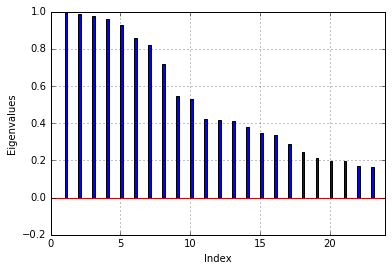

In [15]:
plt.close('all')

plt.figure()
tmpy = M.eigenvalues()
tmpx = range(1, 1+len(tmpy))
plt.bar(tmpx, tmpy, width=.2)
plt.axhline(0, c='r')
plt.ylabel('Eigenvalues'); 
plt.xlabel('Index'); 
plt.xlim(0,24)
plt.gca().grid(True)

plt.savefig('{}/eigenvalues_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)


   i     eigenval          its        ratio
   2       0.9876       0.6386
------------------------------------- 1.9020
   3       0.9765       0.3358
------------------------------------- 1.6976
   4       0.9604       0.1978
------------------------------------- 1.9019
   5       0.9260       0.1040
------------------------------------- 2.0159
   6       0.8564       0.0516
------------------------------------- 1.2798
   7       0.8200       0.0403
------------------------------------- 1.6779
   8       0.7168       0.0240
------------------------------------- 1.8012
   9       0.5489       0.0133
------------------------------------- 1.0647
  10       0.5280       0.0125
------------------------------------- 1.3396
  11       0.4251       0.0094
------------------------------------- 1.0232
  12       0.4167       0.0091
------------------------------------- 1.0074
  13       0.4141       0.0091
------------------------------------- 1.0957
  14       0.3805       0.0083
-------------

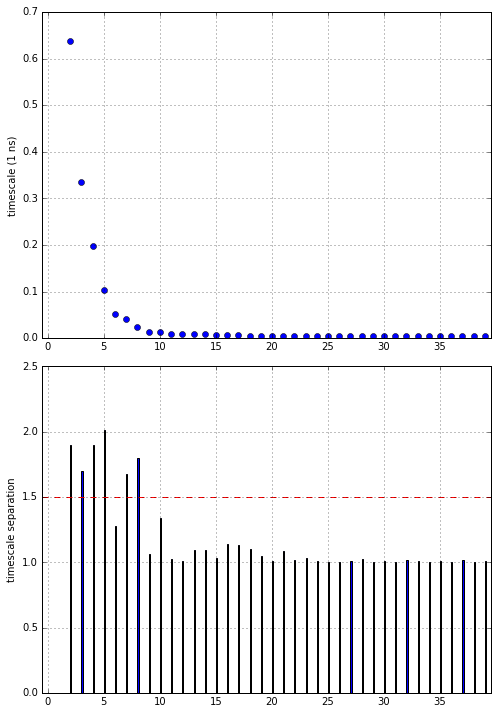

In [16]:
print ('{:>4} {:>12} {:>12} {:>12}'.format('i', 'eigenval', 'its', 'ratio'))
for i in range(18):
    print ('{:4} {:>12.4f} {:>12.4f}'.format(i+2, M.eigenvalues()[i+1], ns_per_frame*M.timescales()[i], M.timescales()[i]/M.timescales()[i+1]))
    print ('------------------------------------- {:>6.4f}'.format( M.timescales()[i]/M.timescales()[i+1]))

    # Show eigenvalue separation
plt.close('all')

plt.figure(figsize=(7,10))
plt.subplot(211)
tmpy = ns_per_frame * M.timescales()
tmpx = range(2, 2+len(tmpy))
plt.plot(tmpx, tmpy,linewidth=0,marker='o')
plt.ylabel('timescale (1 ns)'); 
plt.xlim(-0.5,39.5)
plt.ylim(0,min(10, plt.ylim()[1]))
plt.gca().grid(True)


plt.subplot(212)
tmpy_ = M.timescales()[:-1]/M.timescales()[1:]
tmpx_ = range(2, 2+len(tmpy_))
plt.bar(tmpx_, tmpy_, width=.1)#, linewidth=0,marker='o')
plt.axhline(1.5, c='r', ls='--')
plt.ylabel('timescale separation'); 
plt.xlim(-0.5,39.5)
plt.ylim(0, 2.5)
plt.gca().grid(True)

plt.tight_layout()
plt.savefig('{}/eigenval_separation_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)

Simulate trajectories from MSM
----

In [20]:
class gentrajs:
    def __init__(self,  Ntrajs, Nframes, transmat,cc):
        self.transmat = transmat
        self.Ntrajs = Ntrajs
        self.Nframes = Nframes
        self.cc = cc
        self.dtrajs = generate_trajs(self.transmat, trjs, self.Nframes)
    
    
    def wrapped(self):
        dtrajs_z = self.cc[self.dtrajs, 1]
        return  dtrajs_z
    
    def unwrapped(self, D, msm_lag, dt, crystal_c):
        allz = []
        dtrajs = self.dtrajs
        for dtraj in dtrajs:
            
            # tmp z coords and dz
            dtraj_z = self.cc[dtraj, 1]
            dz = np.diff(dtraj_z)
            
            # possible periodic images +-pm
            pm = 2
            dz_list = np.tile(dz, (2*pm+1, 1))
            dz_list += crystal_c * np.arange(-pm, pm+1)[:,np.newaxis]

            # probability distribution functions
            factor = np.exp(-np.abs(dz_list) / np.sqrt(D*msm_lag*dt))  # exponential

            # select periodic image at random from pdf
            prob = np.cumsum(factor, axis=0) / np.sum(factor, axis=0)
            for i in range(np.shape(prob)[1]):
                u = np.random.uniform()
                select = np.digitize(u, prob[:,i])
                dz[i] = dz_list[select, i]
            
            # convert dz to "unwrapped" z
            dz = np.insert(dz,0,0)
            z = np.cumsum(dz)
            z += dtraj_z[0]

            allz.append(z)
            
        return allz
        

max_ns = 1000
gen = gentrajs(500, int(max_ns/ns_per_frame/msm_lag), M.transition_matrix, clustering.clustercenters)

Check z displacements
----

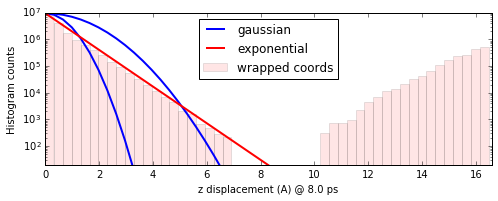

In [21]:
gen_wrapped = gen.wrapped()

plt.figure(figsize=(8,6))
D = .025
D2 = .1

plt.subplot(211)
hdat, bin_edges, _ = plt.hist(np.hstack(np.abs(np.diff(gen_wrapped, axis=1))), bins=50, color='r', alpha=.1, label='wrapped coords')
#plt.hist(np.hstack(np.abs(np.diff(out[0], axis=1))), bins=bin_edges, color='b', alpha=.2, label='unwrapped coords')

plt.plot(bin_edges, np.amax(hdat)*np.exp(-bin_edges**2/(4*D*msm_lag*ps_per_frame)), c='b', lw=2, label='gaussian')
plt.plot(bin_edges, np.amax(hdat)*np.exp(-bin_edges**2/(4*D2*msm_lag*ps_per_frame)), c='b', lw=2)
plt.plot(bin_edges, np.amax(hdat)*np.exp(-np.abs(bin_edges)/np.sqrt(2*D*msm_lag*ps_per_frame)), c='r', lw=2, label='exponential')

plt.xlim(0, crystal['c'])
plt.gca().set_yscale('log')
plt.ylim(20, plt.ylim()[1])
plt.legend(loc='best')
plt.xlabel('z displacement (A) @ {:.1f} ps'.format(msm_lag*ps_per_frame))
plt.ylabel('Histogram counts')


Notice that displacements seem to follow exponential distribution with D = 1.8e-9 m2/s.

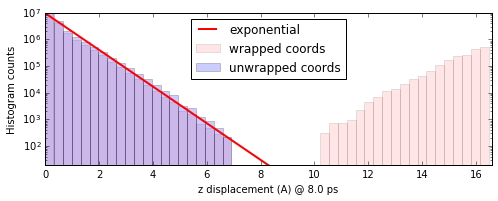

In [22]:
gen_unwrapped = gen.unwrapped(D, msm_lag, ps_per_frame, crystal['c'])

plt.figure(figsize=(8,6))

plt.subplot(212)
hdat, bin_edges, _ = plt.hist(np.hstack(np.abs(np.diff(gen_wrapped, axis=1))), bins=50, color='r', alpha=.1, label='wrapped coords')
plt.hist(np.hstack(np.abs(np.diff(gen_unwrapped, axis=1))), bins=bin_edges, color='b', alpha=.2, label='unwrapped coords')

plt.plot(bin_edges, np.amax(hdat)*np.exp(-np.abs(bin_edges)/np.sqrt(2*D*msm_lag*ps_per_frame)), c='r', lw=2, label='exponential')

plt.xlim(0, crystal['c'])
plt.gca().set_yscale('log')
plt.ylim(20, plt.ylim()[1])
plt.legend(loc='best')
plt.xlabel('z displacement (A) @ {:.1f} ps'.format(msm_lag*ps_per_frame))
plt.ylabel('Histogram counts')



plt.savefig('{}/generated_trjs_distributions.png'.format(activedir), dpi=144)
print

View z component of trajectories
----

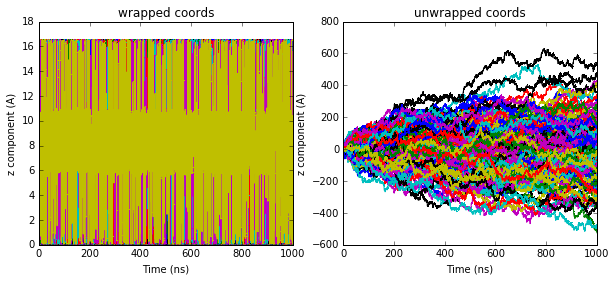

In [23]:
plt.close('all')

plt.figure(figsize=(10,4))

plt.subplot(122)
for i in gen_unwrapped:
    plt.plot(msm_lag*ns_per_frame*np.arange(len(i))[::40], i[::40], marker=',')
plt.xlabel('Time (ns)')
plt.ylabel('z component (A)')
plt.title('unwrapped coords')
    
plt.subplot(121)
for i in gen_wrapped:
    plt.plot(msm_lag*ns_per_frame*np.arange(len(i))[::40], i[::40], marker=',')
plt.xlabel('Time (ns)')
plt.ylabel('z component (A)')
plt.title('wrapped coords')

plt.savefig('{}/simulated_fake_trjs.png'.format(activedir), dpi=144)


Calculate MSD from trajectories
----

In [24]:
def msd(z):

    allmsd = np.zeros(np.shape(z)[1])
    counts = np.zeros(np.shape(z)[1])
    
    stride = 8
    
    for i in z:
        for j in range(1, len(i), stride):
            msd = np.mean((i[j:] - i[:-j])**2)
            allmsd[j] += msd
            counts[j] += 1

    for i,v in enumerate(allmsd):
        if counts[i]!=0:
            allmsd[i] = v/counts[i]
        
    y = np.trim_zeros(allmsd, trim='b')
    
    x = np.arange(len(y), dtype=float)
    x *= (msm_lag * ps_per_frame)  # convert from frames to ps

    return x[1::stride], y[1::stride]


generated_t, generated_msd = msd(gen_unwrapped)

Show MSD vs time
----

200008.0 499976.0
D  = 2.10e-10 m2 s-1


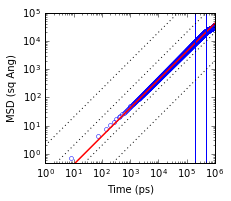

In [29]:
# plot MSD vs t
plt.figure(figsize=(3.3,3))
plt.subplot(111)
plt.plot(generated_t, generated_msd, '.', ms=8, markerfacecolor='none')

# line fit to data
tmpind1 = int(.2*len(generated_t))
tmpind2 = int(.5*len(generated_t))
print generated_t[tmpind1], generated_t[tmpind2]
tmpx = generated_t[tmpind1:tmpind2]
tmpy = generated_msd[tmpind1:tmpind2]
m, b = np.polyfit(tmpx, tmpy, 1)
print ('D  = {:.2e} m2 s-1'.format(0.5*m*1e-8))
plt.plot([1e0,1e12], [m*j for j in [1e0,1e12]], c='r', ls='-', lw=1.5)
plt.axvline(generated_t[tmpind1])
plt.axvline(generated_t[tmpind2])

# guide lines
for i in [-8, -9, -10, -11]:
    plt.plot([1e0,1e12], [2*10**(i+8)*j for j in [1e0,1e12]], c='k', ls=':')


plt.xlim(1e0, max_ns*1000)
plt.ylim(.5, 100000)
plt.gca().set_aspect('equal')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Time (ps)')
plt.ylabel('MSD (sq Ang)')

#plt.plot(*np.loadtxt('/home/vargaslo/ws/MDAnalysisTools/prop160_298k_micro.dat'), c='r', marker='.')
plt.tight_layout()
plt.savefig('{}/msd_for_truncated_orig.png'.format(activedir), dpi=144)

Chapman-Kolmogorov test
----

In [30]:
n_sets = 10

# ck test
if 1:
    mlags = sorted(list(set(np.insert(np.linspace(1, (350.)/msm_lag, 5, dtype=int),0,0))))
    print mlags
    print [i*msm_lag for i in mlags]

#    ck = pyemma.msm.ChapmanKolmogorovValidator(MyMSM)
    ck = M.cktest(n_sets, mlags=mlags, err_est=False)

[0, 1, 11, 22, 33, 43]
[0, 8, 88, 176, 264, 344]


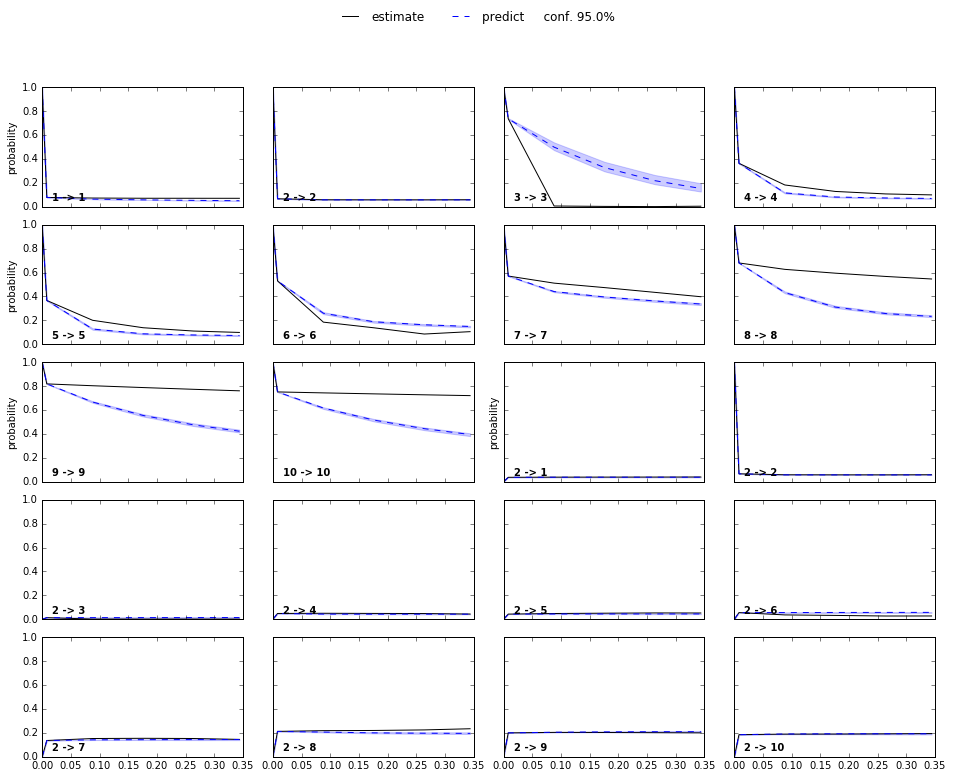

In [31]:
try:
    plt.close('all')
    plt.figure()
    layout = int(np.ceil(np.sqrt(n_sets)))
    mplt.plot_cktest(ck, diag=True, figsize=(16,12), layout=(5,4), padding_top=0.1, y01=True, padding_between=0.15, dt=ns_per_frame, units='ns')
    #plt.savefig('{}/cktest_nclust{}_lag{}_nsets{}.png'.format(activedir, n_clusters, msm_lag, n_sets), dpi=144)
except:
    print "Figure not created"
    pass

In [ ]:
print ns_per_frame